In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.preprocessing import TimeSeriesDifferentiator
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_absolute_error, mean_squared_error



sns.set(style="whitegrid", palette="YlOrRd_r")

In [4]:
ROOT_DIR = os.path.abspath('.')
DATA_DIR = os.path.join(ROOT_DIR, 'data')
FILE = os.path.join(DATA_DIR, '{name_file}')

In [5]:
df_pedido = pd.read_excel(FILE.format(name_file='PEDIDO-_1_.xlsx'), names=['ID_PEDIDO', 'DATA', 'VALOR_TOTAL'])
df_pedido['ID_PEDIDO'] = df_pedido['ID_PEDIDO'].astype('object')
df_pedido['DATA'] = pd.to_datetime(df_pedido['DATA'])
df_pedido = df_pedido[['ID_PEDIDO', 'DATA']].drop_duplicates()
df_pedido

,ID_PEDIDO,DATA
0,120210601,2021-06-01
1,220210601,2021-06-01
2,320210604,2021-06-04
3,420210604,2021-06-04
5,520210604,2021-06-04
...,...,...
287,14420210830,2021-08-30
288,14520210830,2021-08-30
289,14520210831,2021-08-31
292,14620210901,2021-09-01


In [6]:
df_item_pedido = pd.read_excel(FILE.format(name_file='ITEM_PEDIDO-_2_.xlsx'), names=['ID_PEDIDO', 'ID_ITEM', 'QUANTIDADE'])
df_item_pedido['ID_PEDIDO'] = df_item_pedido['ID_PEDIDO'].astype('object')
df_item_pedido = df_item_pedido[['ID_PEDIDO', 'ID_ITEM', 'QUANTIDADE']].drop_duplicates()
df_item_pedido

,ID_PEDIDO,ID_ITEM,QUANTIDADE
0,120210601,item C,4
1,220210601,item A,3
2,320210604,item C,1
3,420210604,item B,4
4,420210604,item C,2
...,...,...,...
290,14520210831,item C,5
291,14520210831,item A,3
292,14620210901,item D,2
293,14720210901,item A,1


In [7]:
df_item = pd.read_excel(FILE.format(name_file='ITENS-_3_.xlsx'))
df_item = df_item.rename(columns={'Unnamed: 0': 'ID_ITEM', 0:'VALOR_ITEM'})
df_item

,ID_ITEM,VALOR_ITEM
0,item A,10
1,item B,15
2,item C,20
3,item D,25


In [8]:
df = pd.merge(left=df_item_pedido, right=df_item, how='left', on='ID_ITEM')
df = pd.merge(left=df, right=df_pedido[['ID_PEDIDO', 'DATA']], how='left', on='ID_PEDIDO')
df

,ID_PEDIDO,ID_ITEM,QUANTIDADE,VALOR_ITEM,DATA
0,120210601,item C,4,20,2021-06-01
1,220210601,item A,3,10,2021-06-01
2,320210604,item C,1,20,2021-06-04
3,420210604,item B,4,15,2021-06-04
4,420210604,item C,2,20,2021-06-04
...,...,...,...,...,...
286,14520210831,item C,5,20,2021-08-31
287,14520210831,item A,3,10,2021-08-31
288,14620210901,item D,2,25,2021-09-01
289,14720210901,item A,1,10,2021-09-01


### FUNÇÕES

In [9]:
def select_dataset(df_dt, df_ts, item):
    df_ = df_dt.merge(df_ts.loc[df_ts['ID_ITEM'] == item], left_index=True, right_index=True, how='left')
    df_['QUANTIDADE'] = df_['QUANTIDADE'].fillna(0).astype('int64')
    df_ = df_.drop(columns=['ID_ITEM'])
    return df_

In [10]:
def get_metrics(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = mean_squared_error(y_test, y_predict, squared=False)

    print(f'mae = {mae}')
    print(f'mse = {mse}')
    print(f'rmse = {rmse}')
    return mae, mse, rmse

In [75]:
def plot_result(y_train, y_test, y_predict, name):
    fig, ax = plt.subplots()

    sns.lineplot(x=y_train.index, y=y_train, label='train', ax=ax, color='orange', marker="o")
    sns.lineplot(x=y_test.index, y=y_test, label='Real', ax=ax, marker='o')
    sns.lineplot(x=y_test.index, y=y_predict, label='Previsão', ax=ax, color='b', marker="o")


    # x_interval = y_train.index.to_list() + y_test.index.to_list()
    # ax.set(xticks=x_interval)

    ax.figure.set_size_inches(12,8)
    ax.set_title(f'Previsão da Quantidade de itens {name} vendidos por dia', loc='left', fontsize=18)
    ax.set_xlabel('Data', fontsize=14)
    ax.set_ylabel('Quantidade de itens', fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98))
    sns.despine(bottom = False, left = False)

    ax.tick_params(axis='x', rotation=45);

Selecionado dataframes separados por item

In [76]:
df_ts = df.groupby(['DATA', 'ID_ITEM'], as_index=False).agg({'QUANTIDADE':'sum'})
start_date = str(df_ts['DATA'].min().date())
end_date = str(df_ts['DATA'].max().date())

df_ts = df_ts.set_index('DATA')

date_range = pd.date_range(start=start_date, end=end_date)
df_dt = pd.DataFrame(index=date_range)


df_full_a = select_dataset(df_dt, df_ts, 'item A')
df_full_b = select_dataset(df_dt, df_ts, 'item B')
df_full_c = select_dataset(df_dt, df_ts, 'item C')
df_full_d = select_dataset(df_dt, df_ts, 'item D')

In [77]:
train_size = int(len(df_dt) * 0.8)
dt_ref = df_dt.iloc[train_size:].index[0]
dt_ref

Timestamp('2021-08-14 00:00:00', freq='D')

### Média Móvel Simples

In [78]:
def mms(df_, dt_ref, name):
    df_['RW_3'] = df_['QUANTIDADE'].rolling(window=7).mean()

    df_ = df_.dropna()

    train, test = df_.loc[df_.index < dt_ref], df_.loc[df_.index >= dt_ref]
    y_test = test['QUANTIDADE']
    y_predict = test['RW_3']
    plot_result(train['QUANTIDADE'], y_test, y_predict, name)
    
    return get_metrics(y_test, y_predict)

In [79]:
df_ = df_full_a

df_['RW_3'] = df_['QUANTIDADE'].rolling(window=7).mean()

df_ = df_.dropna()

train, test = df_.loc[df_.index < dt_ref], df_.loc[df_.index >= dt_ref]
y_test = test['QUANTIDADE']
y_predict = test['RW_3']

mae = 1.6842105263157894
mse = 4.8829215896885065
rmse = 2.209733375248812


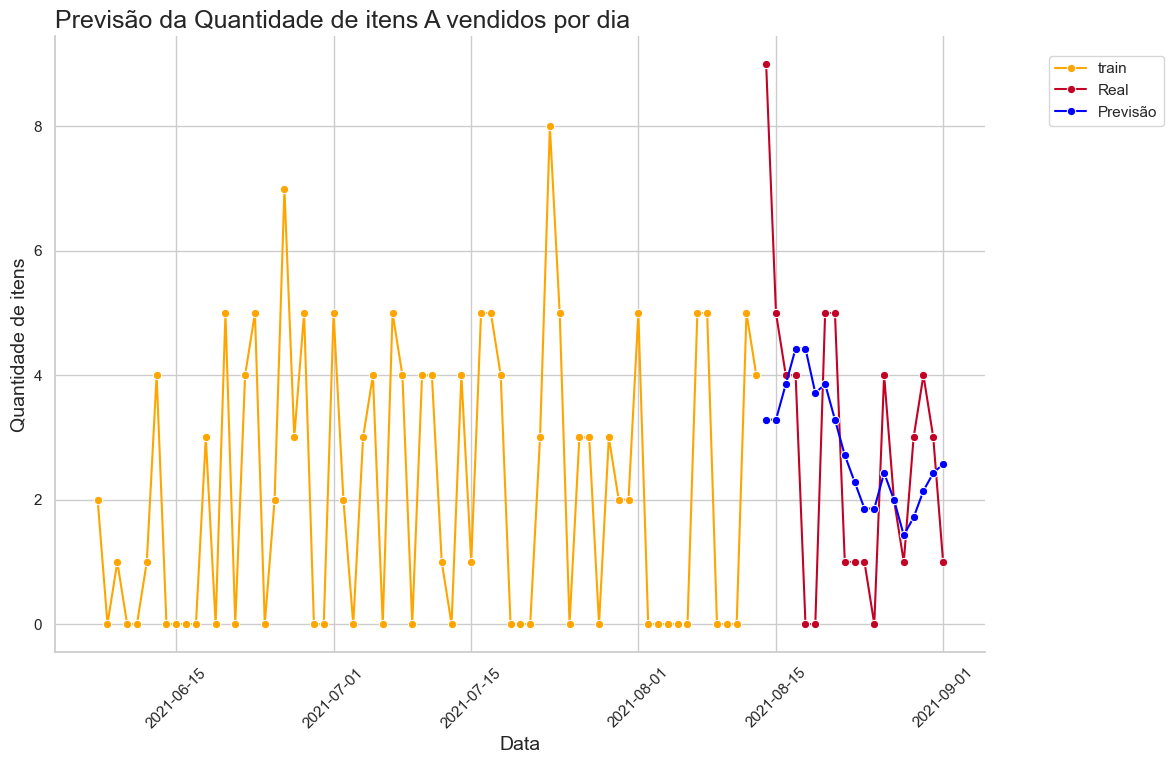

In [80]:
rw_a_mae, rw_a_mse, rw_a_rmse = mms(df_full_a, dt_ref, 'A')

mae = 1.1729323308270678
mse = 2.1740064446831355
rmse = 1.4744512350983792


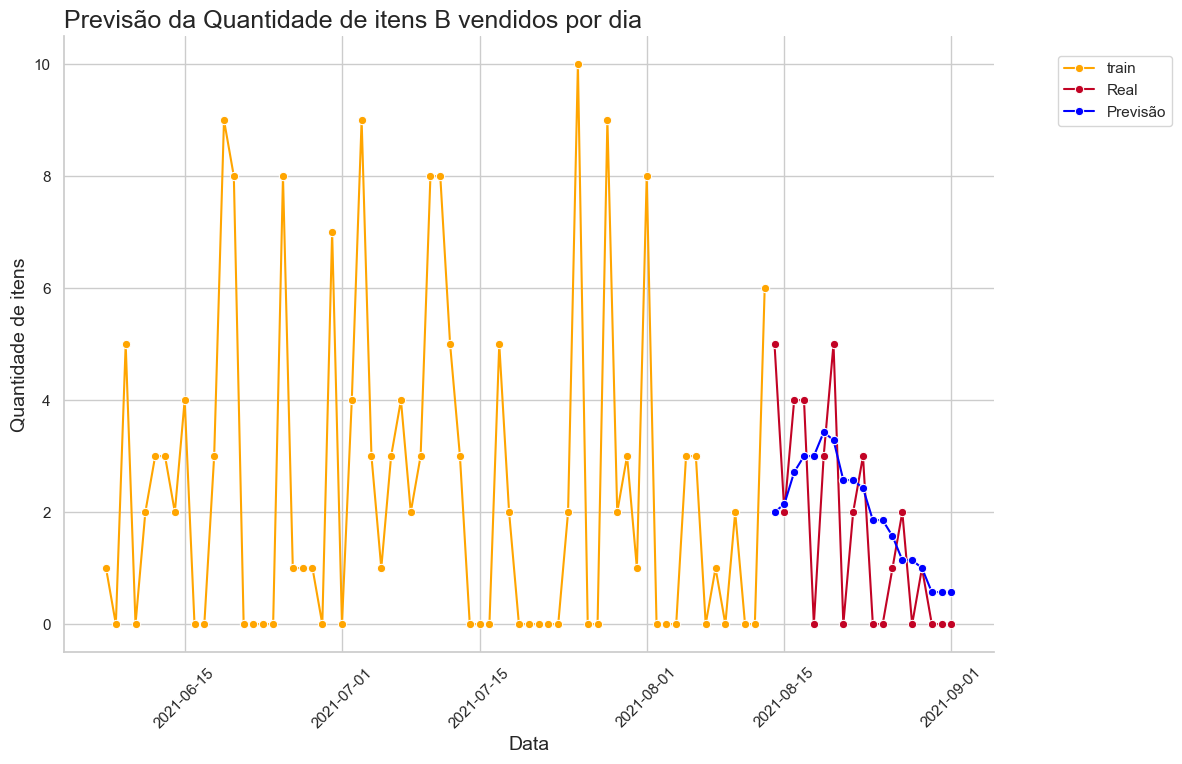

In [81]:
rw_b_mae, rw_b_mse, rw_b_rmse = mms(df_full_b, dt_ref, 'B')

mae = 1.6842105263157894
mse = 3.628356605800215
rmse = 1.9048245603730058


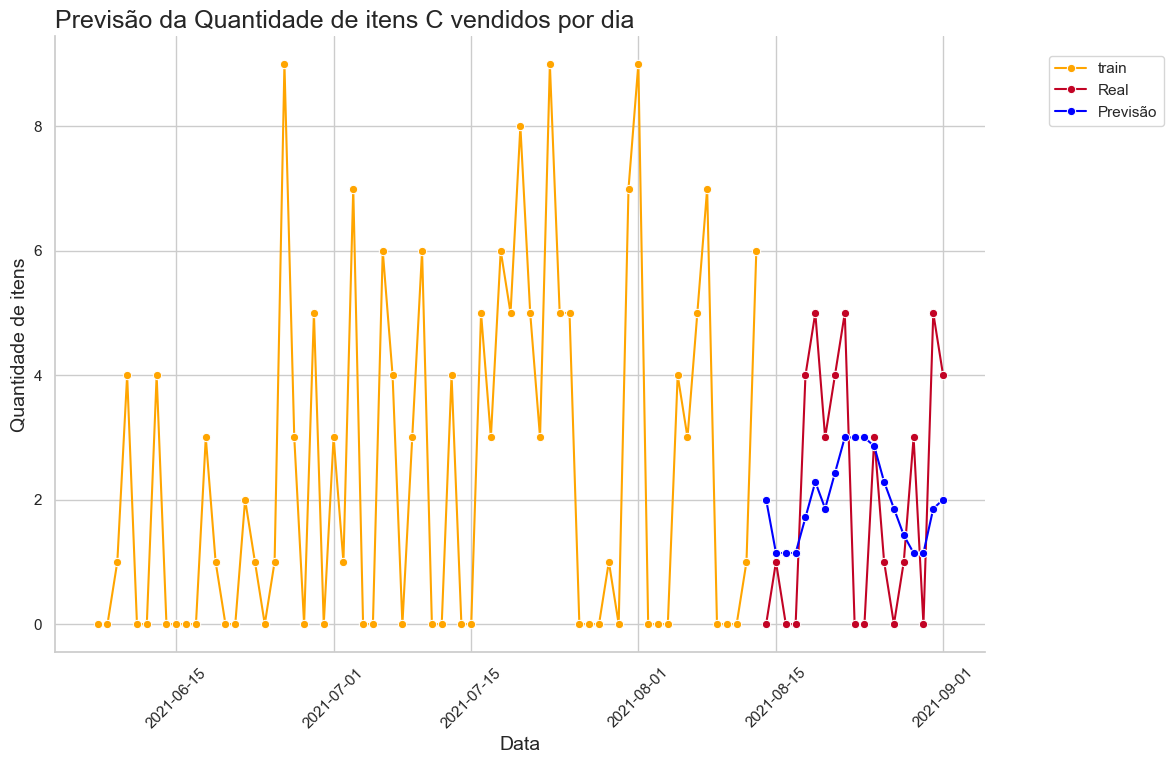

In [82]:
rw_c_mae, rw_c_mse, rw_c_rmse = mms(df_full_c, dt_ref, 'C')

mae = 1.9924812030075187
mse = 6.465091299677766
rmse = 2.542654380697024


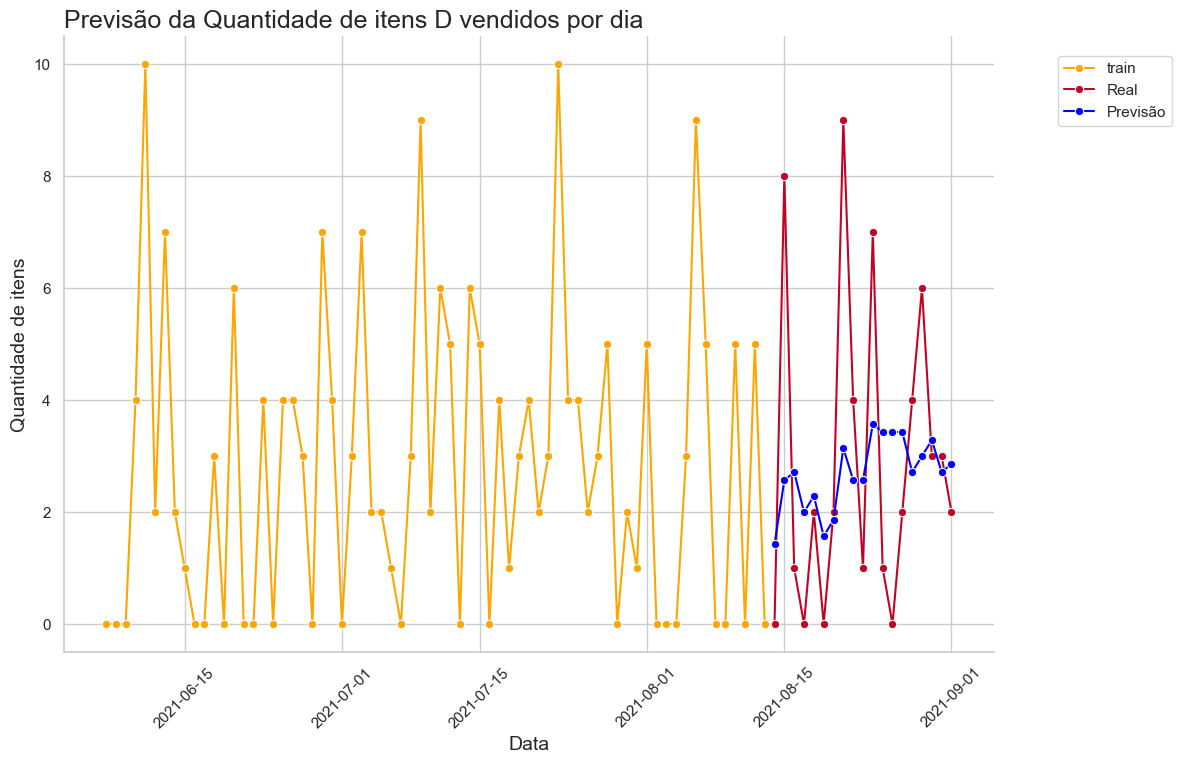

In [83]:
rw_d_mae, rw_d_mse, rw_d_rmse = mms(df_full_d, dt_ref, 'D')

### Regressão linear

In [89]:
def regressao_linear(df_, dt_ref, name):
    df_ = df_[['QUANTIDADE']]

    # Criando features para a regressão linear (usaremos os últimos 15 dias como features)
    for i in range(1, 16):
        df_[f'lag_{i}'] = df_['QUANTIDADE'].shift(i)

    # Removendo as linhas com valores nulos
    df_.dropna(inplace=True)

    # Definindo X (features) e y (variável alvo)
    X = df_.drop('QUANTIDADE', axis=1)
    y = df_['QUANTIDADE']

    # Dividindo o DataFrame para treino e teste
    X_train, X_test, y_train, y_test = X.loc[X.index < dt_ref], X.loc[X.index >= dt_ref], y.loc[y.index < dt_ref], y.loc[y.index >= dt_ref]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Fazendo previsões
    y_pred = model.predict(X_test)

    plot_result(train['QUANTIDADE'], y_test, y_predict, name)
    
    return get_metrics(y_test, y_pred)

mae = 1.729814099131236
mse = 4.718234719809051
rmse = 2.172149792212556


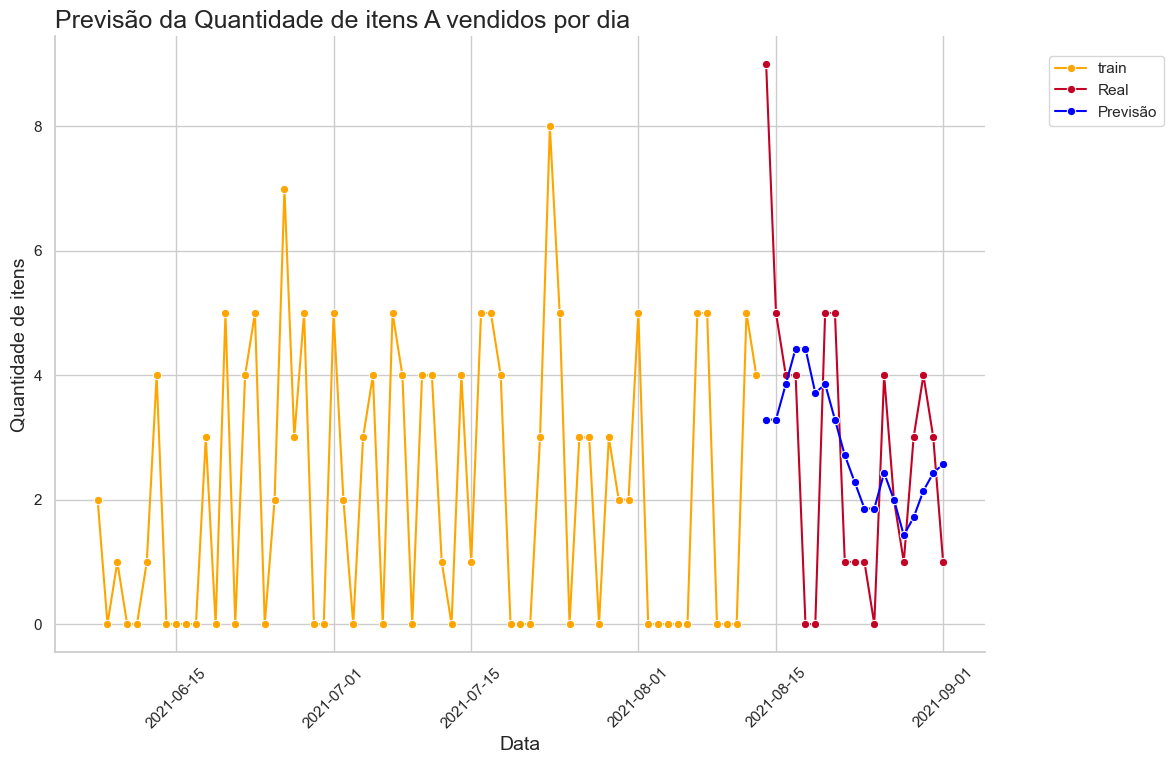

In [90]:
reg_a_mae, reg_a_mse, reg_a_rmse = regressao_linear(df_full_a, dt_ref, 'A')

mae = 1.7048399116539643
mse = 4.759015774214535
rmse = 2.181516851691624


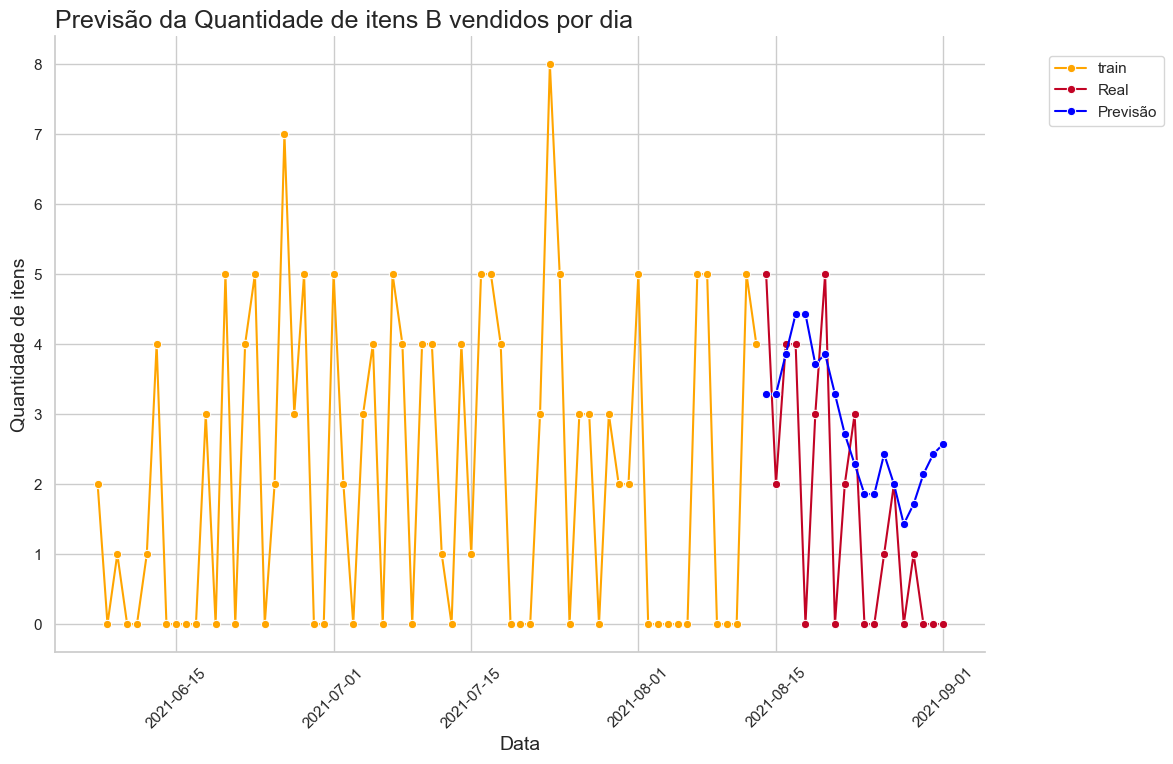

In [91]:
reg_b_mae, reg_b_mse, reg_b_rmse = regressao_linear(df_full_b, dt_ref, 'B')

mae = 2.0111956282722177
mse = 7.468511471173324
rmse = 2.7328577480676386


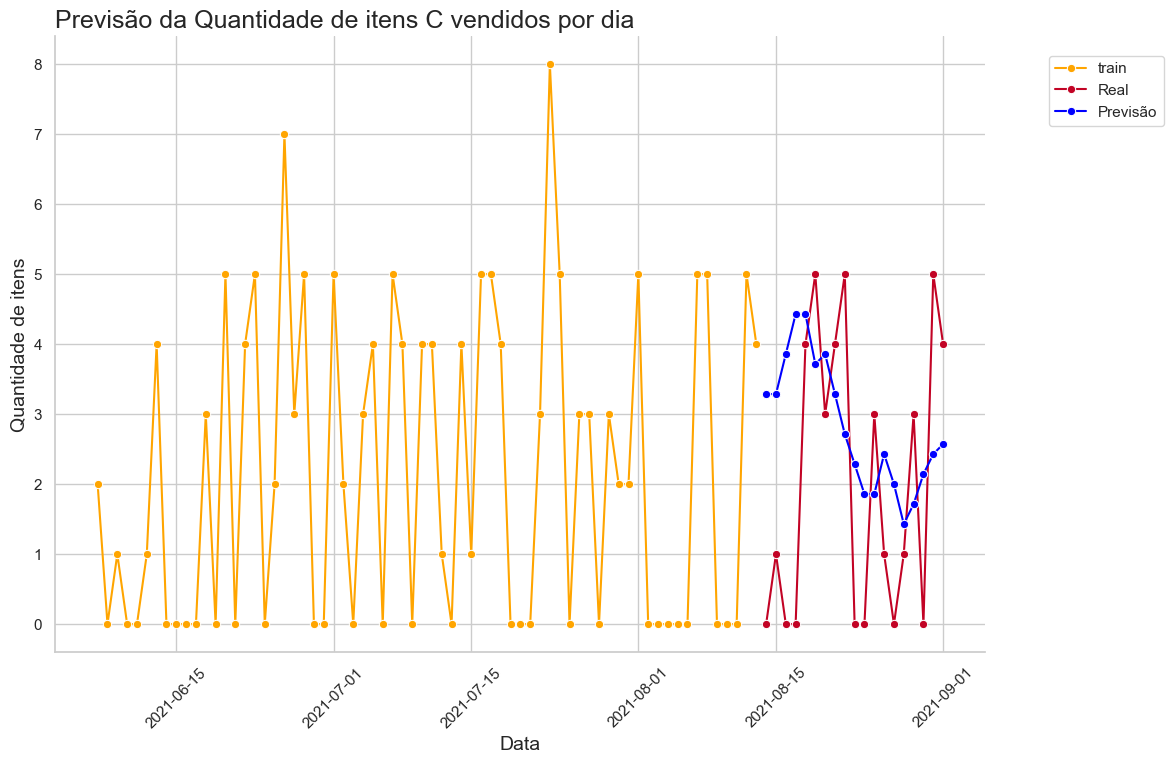

In [92]:
reg_c_mae, reg_c_mse, reg_c_rmse = regressao_linear(df_full_c, dt_ref, 'C')

mae = 1.9808042324878605
mse = 5.200600590339417
rmse = 2.2804825345394377


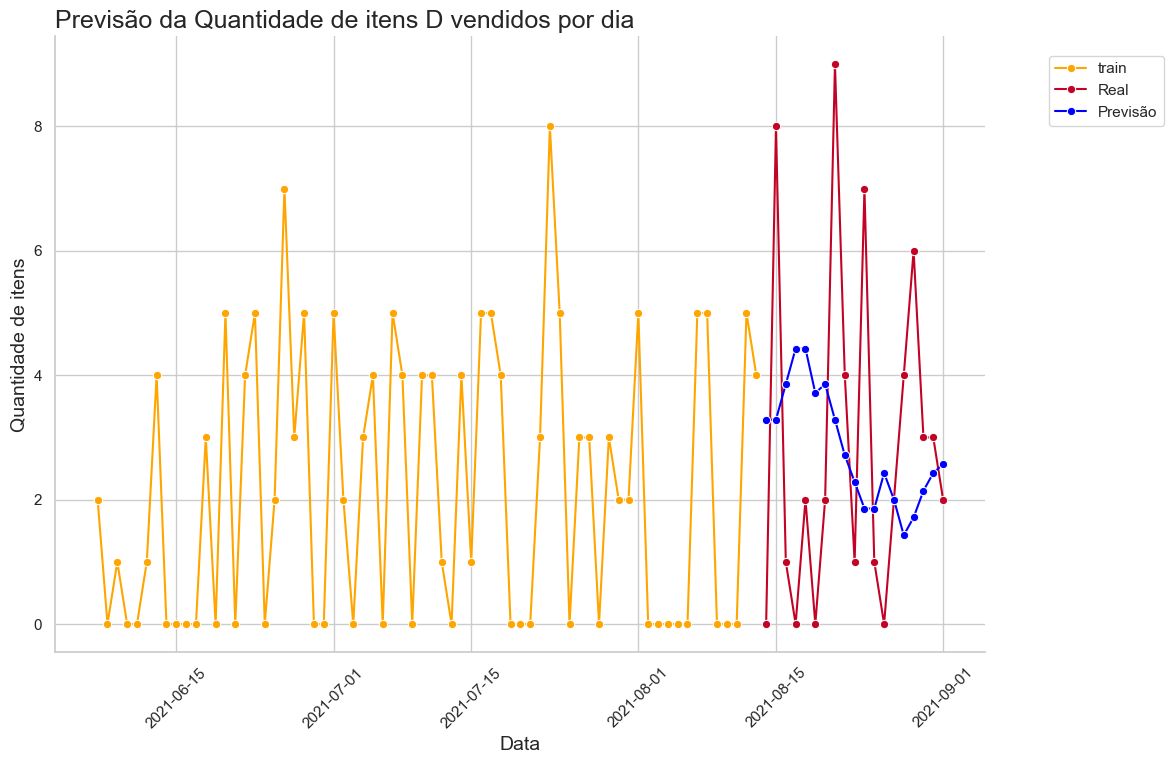

In [93]:
reg_d_mae, reg_d_mse, reg_d_rmse = regressao_linear(df_full_d, dt_ref, 'D')

### Random Forest

In [94]:
def random_forest(df_, dt_ref, name):
    df_ = df_[['QUANTIDADE']]

    # Criando features para a regressão linear (usaremos os últimos 15 dias como features)
    for i in range(1, 16):
        df_[f'lag_{i}'] = df_['QUANTIDADE'].shift(i)

    # Removendo as linhas com valores nulos
    df_.dropna(inplace=True)

    # Definindo X (features) e y (variável alvo)
    X = df_.drop('QUANTIDADE', axis=1)
    y = df_['QUANTIDADE']

    # Dividindo o DataFrame para treino e teste
    X_train, X_test, y_train, y_test = X.loc[X.index < dt_ref], X.loc[X.index >= dt_ref], y.loc[y.index < dt_ref], y.loc[y.index >= dt_ref]

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Fazendo previsões
    y_pred = model.predict(X_test)

    plot_result(train['QUANTIDADE'], y_test, y_predict, name)
    
    return get_metrics(y_test, y_pred)

mae = 1.5484210526315787
mse = 3.588305263157895
rmse = 1.8942822554091285


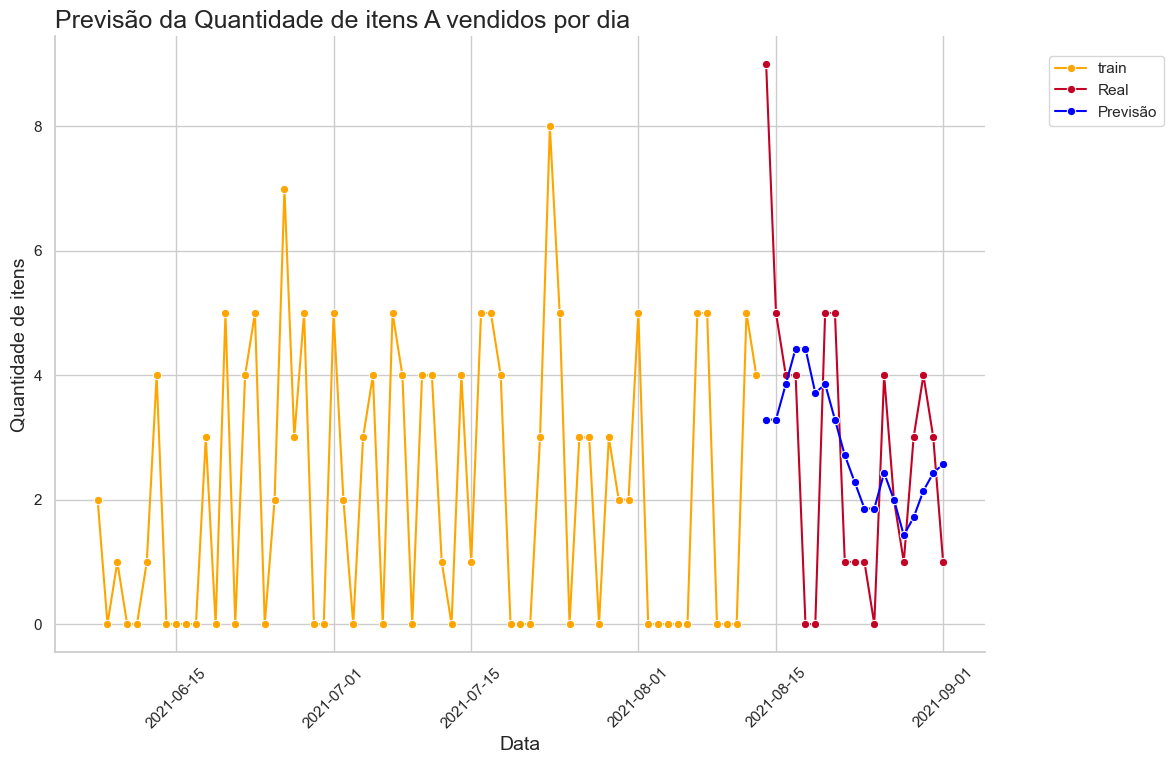

In [95]:
rf_a_mae, rf_a_mse, rf_a_rmse = random_forest(df_full_a, dt_ref, 'A')

mae = 1.5426315789473684
mse = 3.7505631578947374
rmse = 1.9366370743881616


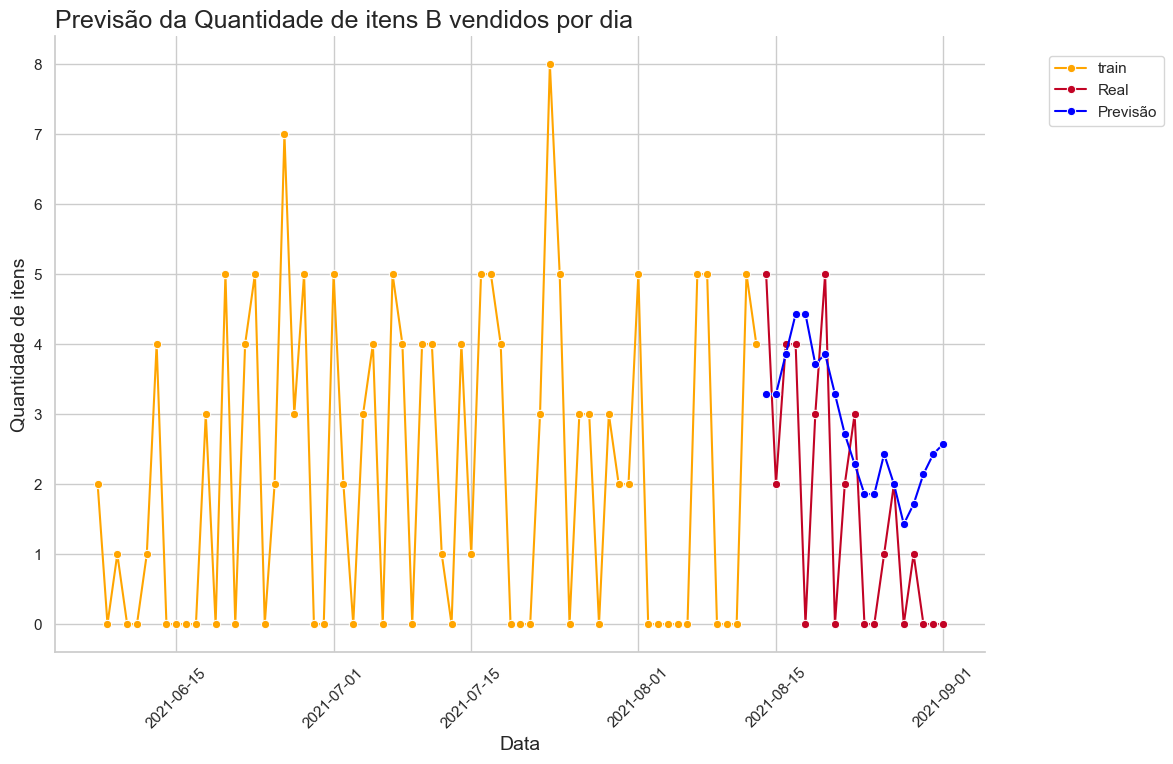

In [96]:
rf_b_mae, rf_b_mse, rf_b_rmse = random_forest(df_full_b, dt_ref, 'B')

mae = 2.097368421052632
mse = 6.588447368421053
rmse = 2.56679710308802


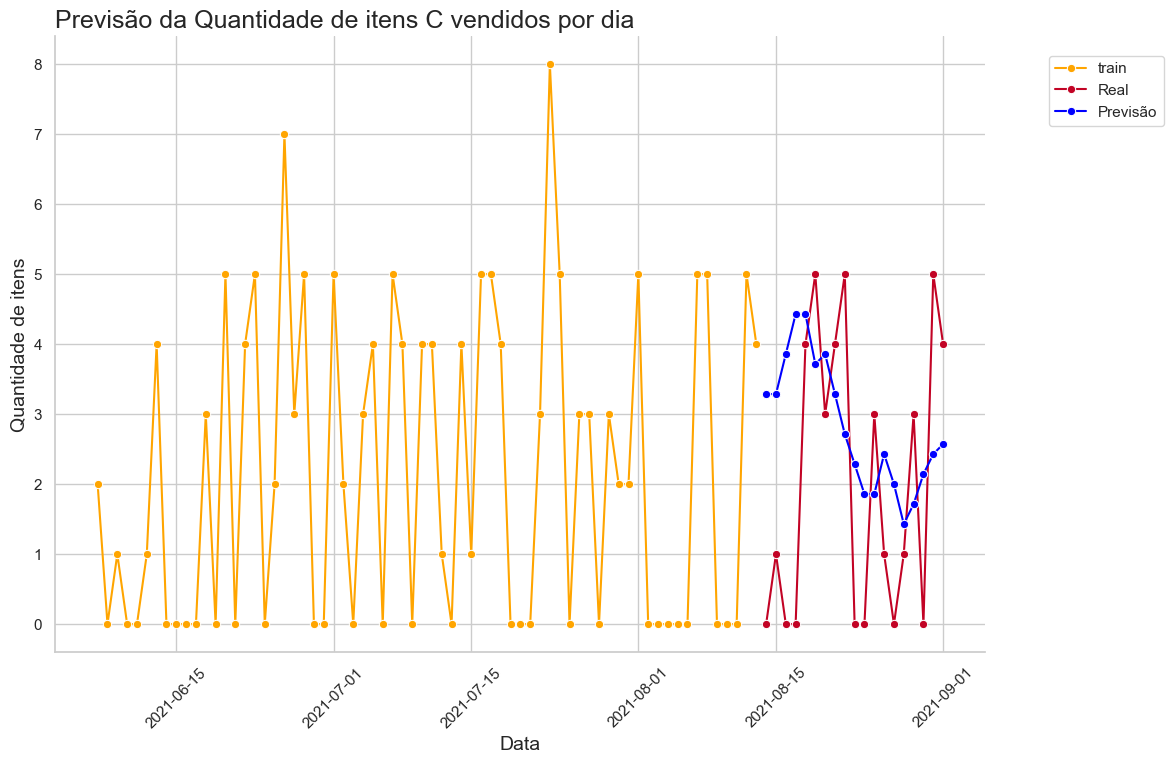

In [97]:
rf_c_mae, rf_c_mse, rf_c_rmse = random_forest(df_full_c, dt_ref, 'C')


mae = 2.268947368421053
mse = 7.1822263157894755
rmse = 2.6799675960334812


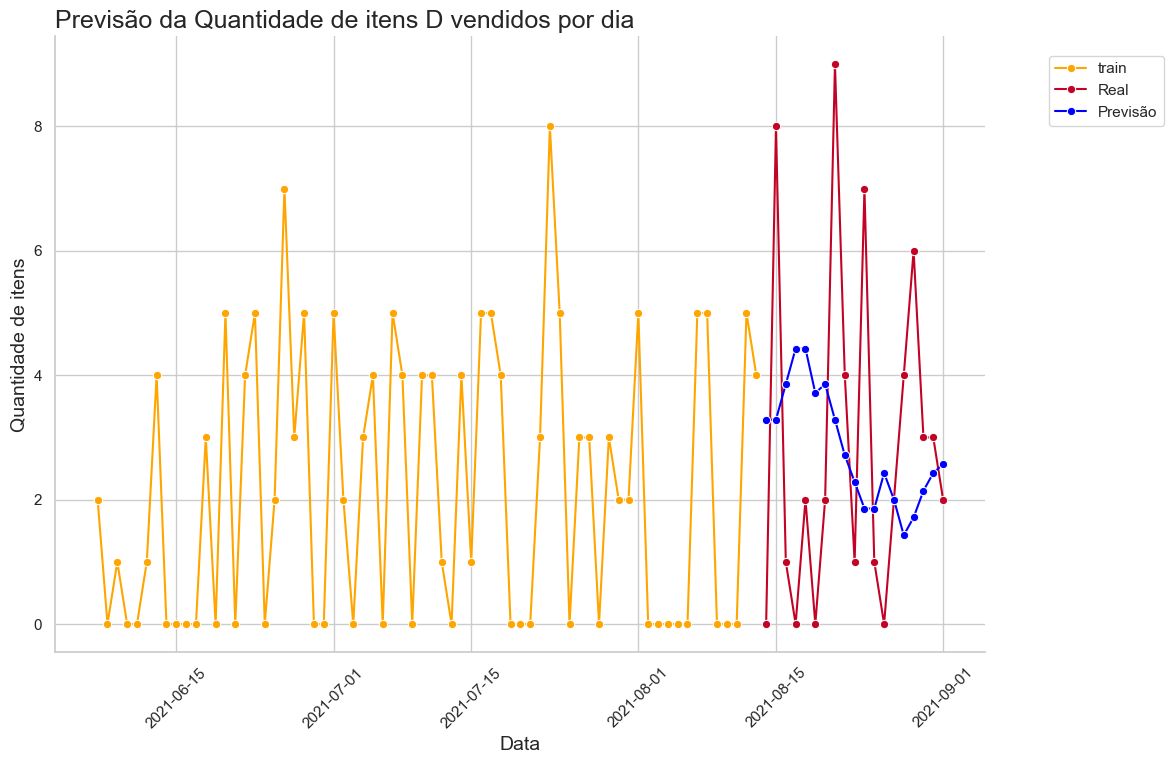

In [98]:
rf_d_mae, rf_d_mse, rf_d_rmse = random_forest(df_full_d, dt_ref, 'D')

### XGBoost

In [265]:
def xgboost_diferential(df_, dt_ref, name):
    data = pd.DataFrame()

    data[['Date', 'QUANTIDADE']] = df_['QUANTIDADE'].reset_index()
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
    data = data.set_index('Date')
    data = data.sort_index()
    data = data['QUANTIDADE']

    # Definindo X (features) e y (variável alvo)
    X = data.loc[:dt_ref]
    y = data.loc[dt_ref:]

    model = ForecasterAutoreg(
                        regressor       = XGBRegressor(random_state=42),
                        lags            = 12,
                        differentiation = 1
                    )

    model.fit(X)

    # Fazendo previsões
    steps = len(y)
    y_pred = model.predict(steps)
    plot_result(X, y, y_pred, name)
    
    return get_metrics(y_test, y_pred)

c:\Users\weslley_almeida\miniconda3\envs\venv_geral\lib\site-packages\skforecast\utils\utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\weslley_almeida\miniconda3\envs\venv_geral\lib\site-packages\skforecast\utils\utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\weslley_almeida\miniconda3\envs\venv_geral\lib\site-packages\skforecast\utils\utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


mae = 3.286246229943476
mse = 14.618154620032005
rmse = 3.823369537467181


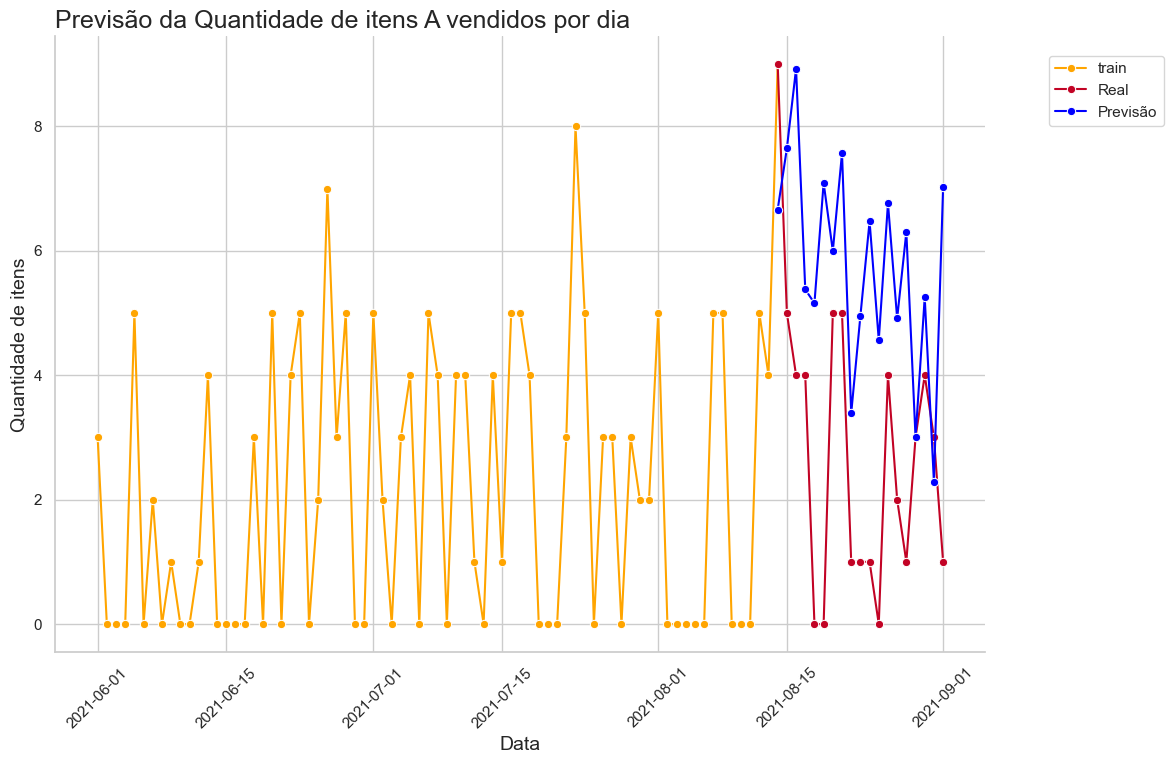

In [267]:
xgb_a_mae, xgb_a_mse, xgb_a_rmse = xgboost_diferential(df_full_a, dt_ref, 'A')

mae = 1.5426315789473684
mse = 3.7505631578947374
rmse = 1.9366370743881616


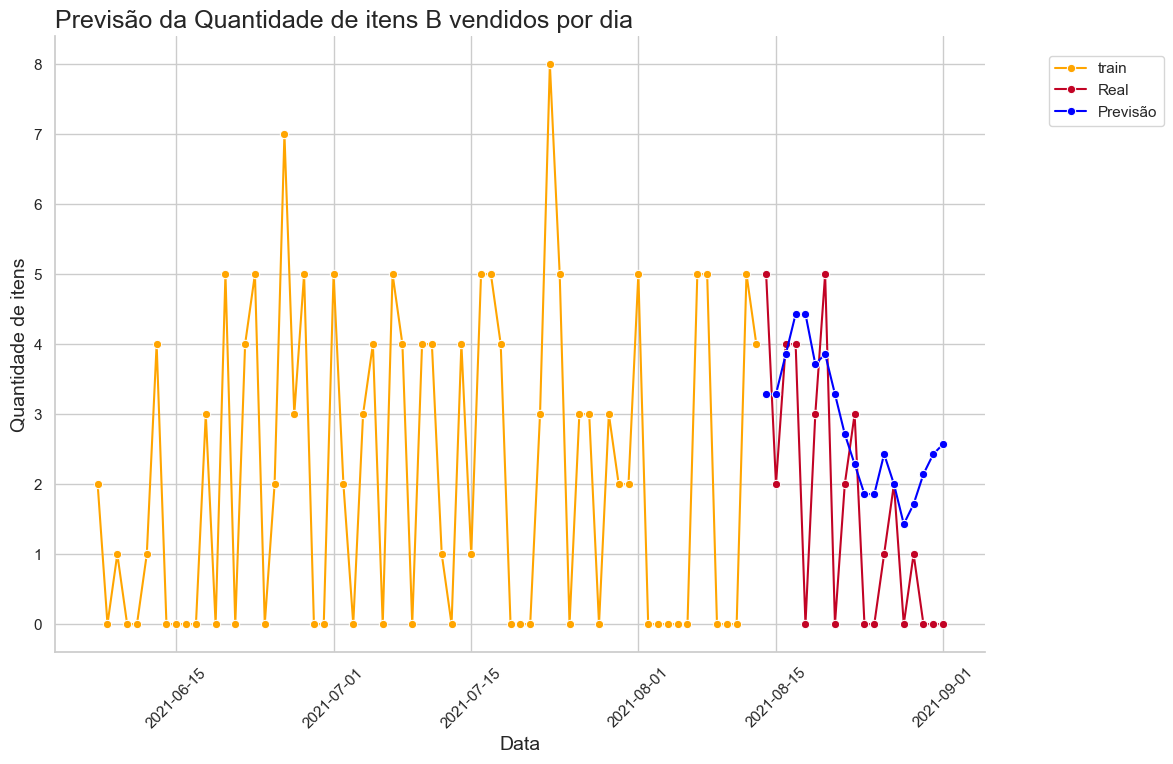

In [268]:
xgb_b_mae, xgb_b_mse, xgb_b_rmse = random_forest(df_full_b, dt_ref, 'B')

c:\Users\weslley_almeida\miniconda3\envs\venv_geral\lib\site-packages\skforecast\utils\utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\weslley_almeida\miniconda3\envs\venv_geral\lib\site-packages\skforecast\utils\utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\weslley_almeida\miniconda3\envs\venv_geral\lib\site-packages\skforecast\utils\utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


mae = 3.778391941597587
mse = 21.8889849146654
rmse = 4.678566544858094


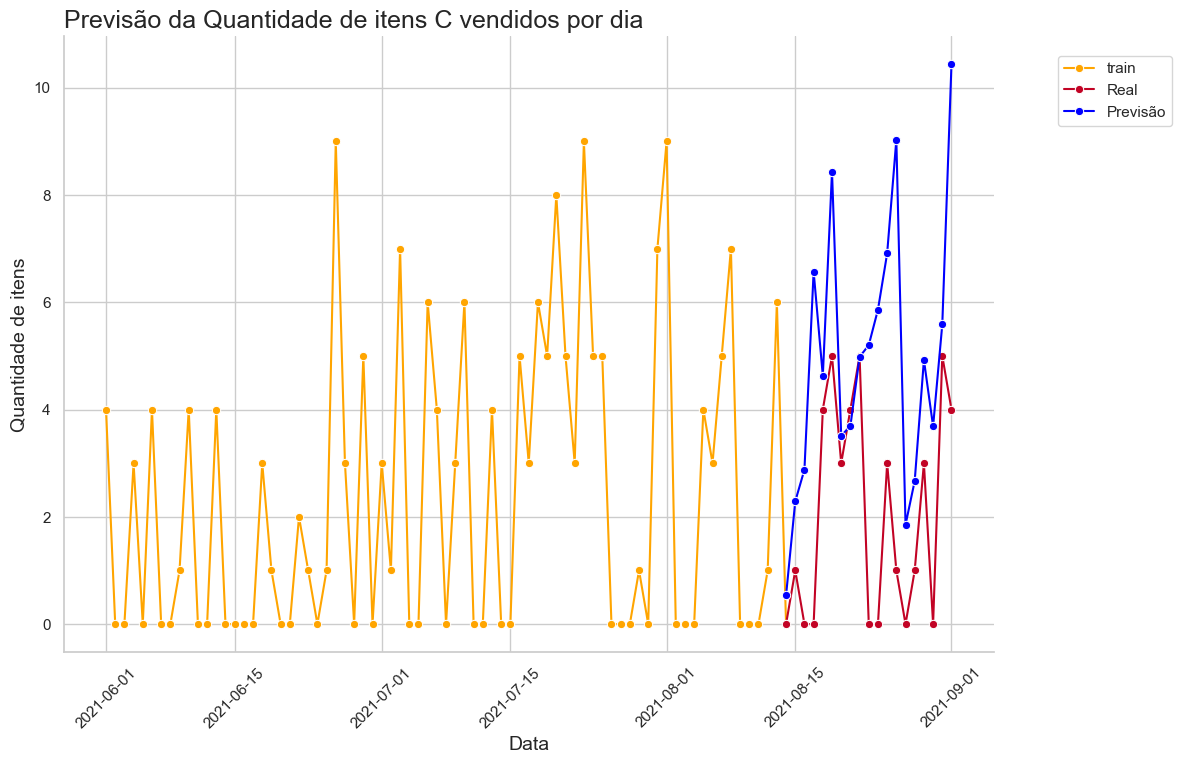

In [269]:
xgb_c_mae, xgb_c_mse, xgb_c_rmse = xgboost_diferential(df_full_c, dt_ref, 'C')

mae = 2.268947368421053
mse = 7.1822263157894755
rmse = 2.6799675960334812


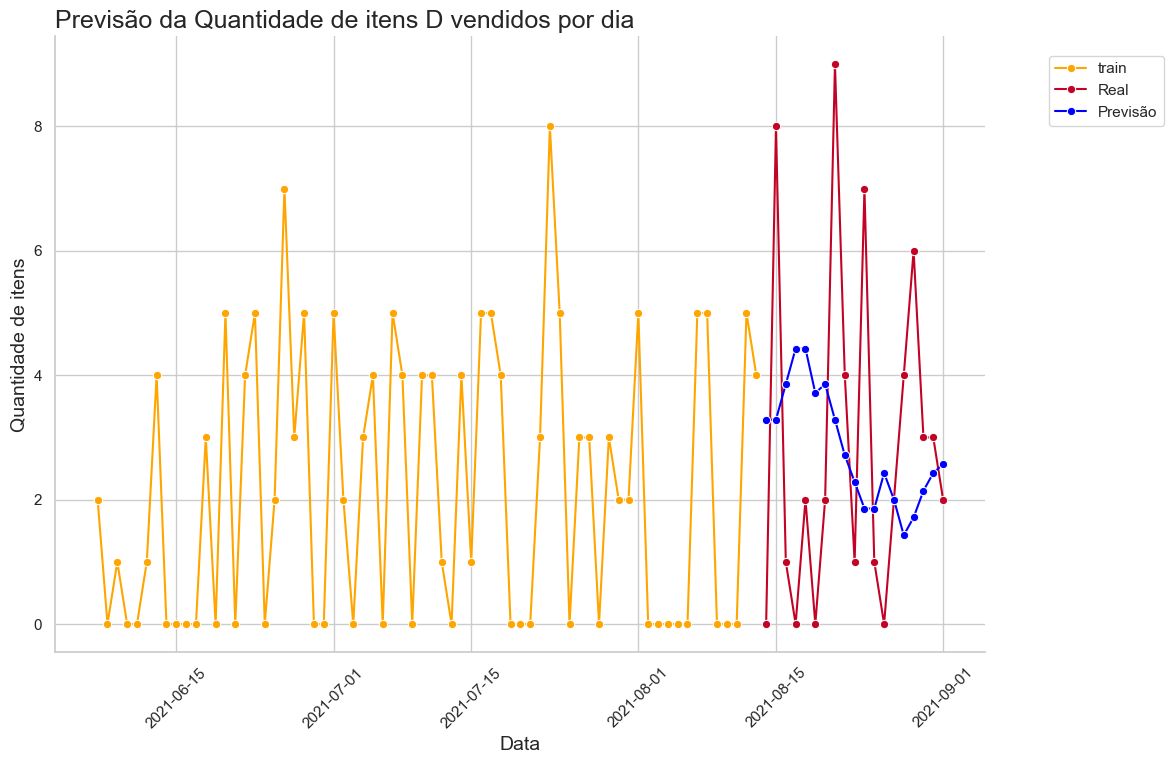

In [270]:
xgb_d_mae, xgb_d_mse, xgb_d_rmse = random_forest(df_full_d, dt_ref, 'D')

## Métricas

In [271]:
metricas = {
    'ITEM A': {'mms': rw_a_rmse, 'regressao': reg_a_rmse, 'random_forest': rf_a_rmse, 'xgboost': xgb_a_rmse},
    'ITEM B': {'mms': rw_b_rmse, 'regressao': reg_b_rmse, 'random_forest': rf_b_rmse, 'xgboost': xgb_b_rmse},
    'ITEM C': {'mms': rw_c_rmse, 'regressao': reg_c_rmse, 'random_forest': rf_c_rmse, 'xgboost': xgb_c_rmse},
    'ITEM D': {'mms': rw_d_rmse, 'regressao': reg_d_rmse, 'random_forest': rf_d_rmse, 'xgboost': xgb_d_rmse},
}


df_metricas = pd.DataFrame(metricas).T
df_metricas

,mms,regressao,random_forest,xgboost
ITEM A,2.209733,2.172150,1.894282,3.823370
ITEM B,1.474451,2.181517,1.936637,1.936637
ITEM C,1.904825,2.732858,2.566797,4.678567
ITEM D,2.542654,2.280483,2.679968,2.679968


In [272]:
df_metricas.mean()

mms              2.032916
regressao        2.341752
random_forest    2.269421
xgboost          3.279635
dtype: float64

Ao observarmos a média, a média móve simples obteve um desempenho superior aos demais, conseguindo errar em apenas ~2 itens a previsão de demanda.

Ressalta-se que modelos mais avançados e complexos poderiam ser utilizados para melhor acuracidade, como XGBoost, Prophet e propriamento modelos estatísticos ARIMA, SARIMA. Pois, tais modelos podem capturar padrões mais sutis e oferecer uma previsão mais precisa em séries temporais mais complexas ou com tendências e sazonalidades.